This tutorial will give an example of how to use Riroriro to calculate the signal-to-noise ratio (SNR) of the gravitational waveform from a given binary merger.

We import the data of a synthetic gravitational waveform generated using the gravitational wave functions of Riroriro (demonstrated in the tutorial example_GW), and the FINDCHIRP trace data for the corresponding waveform. The example waveform is included in this repository, but the FINDCHIRP data files are not included in Github for file size reasons and can instead be found at this link: https://www.dropbox.com/sh/lt8109c0c2eb10c/AADBnYXMGmWOEqCK-XWFZuJLa

You can use any Riroriro gravitational waveform in the format output by waveform_exporter for inputarray (if you choose a system different than the default, remember to also select the corresponding FINDCHIRP trace). We use the data for a binary black hole merger with log(Mc/Msun) = 1.4 and mass ratio q = 0.8. We put this example system at a distance of 1000 Mpc.

In [1]:
import numpy as np

inputarray = np.genfromtxt('example_1.4_0.8.dat')
findchirp_array = np.genfromtxt('findchirp_traces/mergerwave_1.40000_0.800000.dat')

d = 1000.0

In [2]:
import riroriro.snrcalculatorfuns as snr

We calculate the redshift from the input distance and then adjust the strain amplitude to account for the distance and the frequency to account for the effect of redshift.

In [3]:
z = snr.polynomial_redshift(d)
inputarray = snr.redshift_distance_adjustment(inputarray,d,z) #note self-reference

We determine the minimum and maximum of the frequency range of the waveform, which we will need at a later step.

In [4]:
freqmax, freqmin = snr.frequency_limits(inputarray)

We perform an approximation of a Fourier transform on the strain amplitude, using the FINDCHIRP data for the system with the same parameters as calibration.

In [5]:
fourieramp = snr.findchirp_fourier(inputarray,findchirp_array,d,z)

The below plot illustrates the relationship between the transformed amplitude and frequency, similar to figure 18 of the thesis "Gravitational Waveform Synthesis".

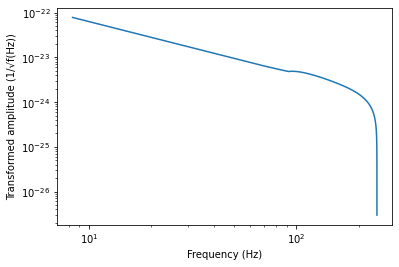

In [6]:
import matplotlib.pyplot as plt

plt.figure(1)
plt.plot(inputarray[:,1],fourieramp)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Transformed amplitude (1/√f(Hz))')
plt.xscale('log')
plt.yscale('log')

Now we compare the transformed amplitude to the noise spectra of three detectors in order to calculate the SNR. These spectra were sourced from https://dcc.ligo.org/LIGO-T1500293/public and are also included in this repository for convenience.

You can also use different noise spectra files, as long as they have the frequency values in the first column and ASD noise levels in the second.

We combine the SNR values from each individual detectors to obtain both the quadrature SNR (if all three detectors were operating simultaneously) and the mean-of-individual SNR (if a non-specific single detector was operating).

In [7]:
ind_SNR = np.empty((3))
for i in range(3): #three detectors
    if i == 0:
        noisearray = np.genfromtxt('noise_spectra/o3_l1.txt') #LIGO Livingston
    elif i == 1:
        noisearray = np.genfromtxt('noise_spectra/o3_h1.txt') #LIGO Hanford
    elif i == 2:
        noisearray = np.genfromtxt('noise_spectra/o3_v1.txt') #Virgo
    #the noise spectra are not included in this repository for copyright reasons,
    #but the ones used for this example can be found at the following link:
    #https://dcc.ligo.org/LIGO-T1500293/public
    
    noise_freq_amp = snr.amplitude_interpolation(inputarray,fourieramp,noisearray,freqmax,freqmin)
    ind_SNR[i] = snr.individual_detector_SNR(noisearray,noise_freq_amp)

quad_SNR = np.sqrt(ind_SNR[0]**2 + ind_SNR[1]**2 + ind_SNR[2]**2)
mean_SNR = (ind_SNR[0] + ind_SNR[1] + ind_SNR[2])/3

print("Livingston SNR is %.1f, Hanford SNR is %.1f, Virgo SNR is %.1f.\n"
     "The quadrature SNR is %.1f.\nThe mean-of-individual SNR is %.1f."
      % (ind_SNR[0],ind_SNR[1],ind_SNR[2],quad_SNR,mean_SNR))

Livingston SNR is 23.3, Hanford SNR is 18.1, Virgo SNR is 8.9.
The quadrature SNR is 30.8.
The mean-of-individual SNR is 16.8.
